In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
!pip install emcee


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## <span style="color:Orange">Problem 1</span>

Suppose you have an algorithm to identify [quasars](https://en.wikipedia.org/wiki/Quasar) from astronomical images, which simply returns `True` or `False`. Using control samples, you have determined that your algorithm has the following performance for real quasars as well as the main contaminants for a quasar sample: galaxies and stars.

| data? | M=quasar | M=galaxy | M=star |
|---|--------|--------|------|
| D=True  |  0.8   |   0.1  |  0.2 |
| D=False |  0.2   |   0.9  |  0.8 |

Implement the following function to calculate the likelihood $P(D\mid M)$ given this information:

In [3]:
def likelihood(D, M):
    """Calculate likelihood of data D given model M.
    
    Parameters
    ----------
    D : bool
        A boolean (True/False) value indicating whether the algorithm identified an
        object as being a quasar or not.
    M : str
        A string ('quasar', 'galaxy', 'star') specifying the assumed model.
        
    Returns
    -------
    float
        The probability of the data given the model.
    """
    # YOUR CODE HERE
    dic = {
        'quasar': {True: 0.8, False: 0.2},
        'galaxy': {True: 0.1, False: 0.9},
        'star': {True: 0.2, False: 0.8}
    }

    return dic[M][D]

In [4]:
# A correct solution should pass these tests.
assert likelihood(True, 'quasar') == 0.8
assert likelihood(False, 'galaxy') == 0.9
assert likelihood(True, 'star') == 0.2
for M in 'quasar', 'galaxy', 'star':
    assert likelihood(True, M) + likelihood(False, M) == 1

The prior probability of each model will vary between images, depending mostly on the local density of stars which can vary a lot (and is especially high when you look through the disk of the Milky Way).

Implement the function below to calculate the prior probabilities of each model for an image based on the expected number of objects of each type:

In [5]:
def prior(num_quasars_expected, num_galaxies_expected, num_stars_expected):
    """Calculate the prior probability of each model.
    
    Parameters
    ----------
    num_quasars_expected : int
        Number of expected quasars.
    num_galaxies_expected : int
        Number of expected galaxies.
    num_stars_expected : int
        Number of expected stars.
    
    Returns
    -------
    dict
        Dictionary of prior probabilities for each model with keys 'quasar',
        'galaxy' and 'star'.
    """
    # YOUR CODE HERE
    total = num_quasars_expected + num_galaxies_expected + num_stars_expected
    return {
        'quasar': num_quasars_expected / total,
        'galaxy': num_galaxies_expected / total,
        'star': num_stars_expected / total
    }

In [6]:
# A correct solution should pass these tests.
assert prior(100, 100, 200) == {'quasar': 0.25, 'galaxy': 0.25, 'star': 0.5}
assert prior(100, 100, 600) == {'quasar': 0.125, 'galaxy': 0.125, 'star': 0.75}

You have now the code necessary to quantify how well your quasar identification algorithm performs in regions with different densities of stars, using the posterior probability $P(\text{quasar}\mid \text{True})$.  For example, if the stellar density increases 3 times (from 200 to 600 per image) with fixed quasar and galaxy densities (100 each), the posterior probability drops from 0.615 to 0.381:

In [7]:
import IPython.display

def Learn(prior, likelihood, *data):
    """Learn from data using Bayesian inference.

    Assumes that the model and data spaces are discrete.

    Parameters
    ----------
    prior : dict
        Dictionary of prior probabilities for all possible models.
    likelihood : callable
        Called with args (D,M) and must return a normalized likelihood.
    data : variable-length list
        Zero or more items of data to use in updating the prior.
    """
    # Initialize the Bayes' rule numerator for each model.
    prob = prior.copy()
    history = [('PRIOR', prior)]
    # Loop over data.
    for D in data:
        # Update the Bayes' rule numerator for each model.
        prob = {M: prob[M] * likelihood(D, M) for M in prob}
        # Calculate the Bayes' rule denominator.
        norm = sum(prob.values())
        # Calculate the posterior probabilities for each model.
        prob = {M: prob[M] / norm for M in prob}
        history.append(('D={}'.format(D), prob))
    # Print our learning history.
    index, rows = zip(*history)
    IPython.display.display(pd.DataFrame(list(rows), index=index).round(3))

In [8]:
Learn(prior(100, 100, 200), likelihood, True)
Learn(prior(100, 100, 600), likelihood, True)

,quasar,galaxy,star
PRIOR,0.250,0.250,0.500
D=True,0.615,0.077,0.308


,quasar,galaxy,star
PRIOR,0.125,0.125,0.750
D=True,0.381,0.048,0.571


## <span style="color:Orange">Problem 2</span>

Suppose you measure a random process that follows an [exponential decay law](https://en.wikipedia.org/wiki/Exponential_decay) for the number $n(t)$ of un-decayed states as a function of time $t$:
$$
\frac{dn}{dt} = -\lambda n \; ,
$$
and want to infer the posterior probability of the decay rate $\lambda$ given your data.

First, implement the function below to evaluate the likelihood of observing $N$ decay times $D = \{t_1, t_2, \ldots\}$ as:
$$
P(D\mid \lambda) = \prod_{i=1}^{N}\, P(t_i\mid \lambda)
$$
where the **un-normalized** probability density for exponential decay is:
$$
P(t\mid \lambda) \propto \exp(-\lambda t) \; .
$$

In [19]:
def decay_likelihood(decay_times, lam):
    """Calculate the normalized likelihood of measured times assuming a decay rate.
    """
    return np.prod(lam * np.exp(-lam * np.array(decay_times)))

In [20]:
# A correct solution should pass these tests.
assert decay_likelihood([], 1) == 1
assert np.round(decay_likelihood([1], 0.1), 4) == 0.0905
assert np.round(decay_likelihood([1], 1.0), 4) == 0.3679
assert np.round(decay_likelihood([1], 1.5), 4) == 0.3347
assert np.round(decay_likelihood([1,2,1], 0.1), 4) == 0.0007
assert np.round(decay_likelihood([1,2,1], 1.0), 4) == 0.0183
assert np.round(decay_likelihood([1,2,1], 1.5), 4) == 0.0084

For our prior, we use the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), which has two hyperparameters $\alpha$ and $\beta$:
$$
P(\lambda\mid \alpha,\beta) = \frac{\beta^\alpha \lambda^{\alpha-1} e^{-\beta\lambda}}{\Gamma(\alpha)} \; .
$$
Implement the function below to evaluate the Gamma distribtion PDF using a numpy expression for the numerator and [scipy.special.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html) for the denominator:

In [21]:
import scipy.special

def gamma_distribution(lam, alpha, beta):
    """Evaluate the gamma distribution.
    """
    return (beta**alpha * lam**(alpha - 1) * np.exp(-beta * lam) / scipy.special.gamma(alpha))

In [22]:
# A correct solution should pass these tests.
import scipy.stats
assert gamma_distribution(1, 0, 1) == 0
assert gamma_distribution(1, 1, 0) == 0
for lam in (0.1, 1, 2):
    for alpha, beta in (1, 1), (2, 1), (2, 2):
        assert np.allclose(
            gamma_distribution(lam, alpha, beta),
            scipy.stats.gamma.pdf(lam, a=alpha, scale=1/beta))

The advantage of this choice of prior is that the evidence integral can be performed analytically:
$$
P(D\mid \alpha,\beta) = \int d\lambda\, P(D\mid\lambda)\, P(P(\lambda\mid \alpha,\beta)
= \frac{\beta^\alpha (\beta + T)^{-(\alpha+N)} \Gamma(\alpha+N)}{\Gamma(\alpha)} \; .
$$
Use this result to convince yourself that the posterior $P(\lambda\mid D,\alpha,\beta)$ is another Gamma distribution, but with different hyperparameter values $\alpha'$ and $\beta'$.  Priors and posteriors with the same functional form for some likelihood are called [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior).

Implement the function below to learn from measured decay times by updating the prior hyperparameters:

In [23]:
def rate_learn(prior_alpha, prior_beta, decay_times):
    """Learn from data to update hyperparameters.
    
    Parameters
    ----------
    prior_alpha : float
        Hyperparameter alpha for the prior Gamma distribution PDF.
    prior_beta : float
        Hyperparameter beta for the prior Gamma distribution PDF.
    decay_times : array
        Array of observed decay times.
        
    Returns
    -------
    tuple
        Tuple (post_alpha, post_beta) of hyperparameter values for the
        posterior Gamma distribution PDF.
    """
    return (prior_alpha + len(decay_times), prior_beta + np.sum(decay_times))

In [24]:
# A correct solution should pass these tests.
assert rate_learn(1, 1, []) == (1, 1)
assert rate_learn(2, 1, []) == (2, 1)
assert rate_learn(1, 2, []) == (1, 2)
assert np.allclose(
    np.round(rate_learn(np.sqrt(10), np.pi, [1,2,1]), 3),
    (6.162, 7.142))

You can use the function below to test your code visually and confirm that better data reduces the influence of the prior:

In [ ]:
def rate_learn_plot(prior_alpha, prior_beta, num_decays, true_lam, seed=123):
    """
    """
    # Generate some random decays using the true decay rate.
    gen = np.random.RandomState(seed=seed)
    decay_times = scipy.stats.expon.rvs(scale=1 / true_lam, size=num_decays, random_state=gen)
    
    # Use Bayes' rule to learn from the data.
    lam = np.linspace(0., 2.5 * true_lam, 250)
    prior = [gamma_distribution(l, prior_alpha, prior_beta) for l in lam]
    like = [decay_likelihood(decay_times, l) for l in lam]
    post_alpha, post_beta = rate_learn(prior_alpha, prior_beta, decay_times) 
    post = [gamma_distribution(l, post_alpha, post_beta) for l in lam]
    
    # Plot a summary of the learning process.
    plt.fill_between(lam, prior, alpha=0.25)
    plt.plot(lam, prior, label='Prior')
    plt.plot(lam, like / np.max(like) * np.max(prior), 'k:', label='Likelihood')
    plt.fill_between(lam, post, alpha=0.25)
    plt.plot(lam, post, label='Posterior')
    plt.axvline(true_lam, c='r', ls='--')
    plt.xlabel('Decay rate $\lambda$')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.xlim(0, lam[-1])
    plt.ylim(0, None)

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
C:\Users\TangyKiwi\AppData\Local\Temp\ipykernel_25100\329289567.py:22: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Decay rate $\lambda$')


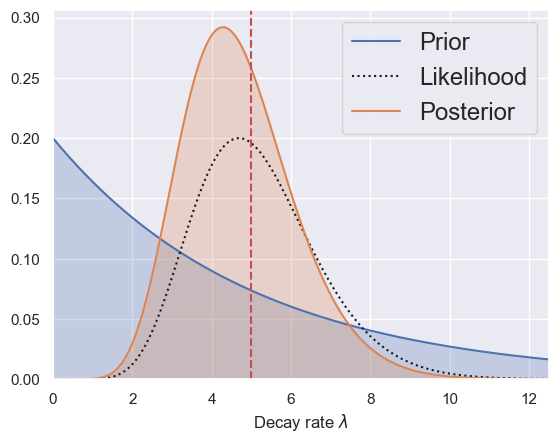

In [26]:
rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=10, true_lam=5)

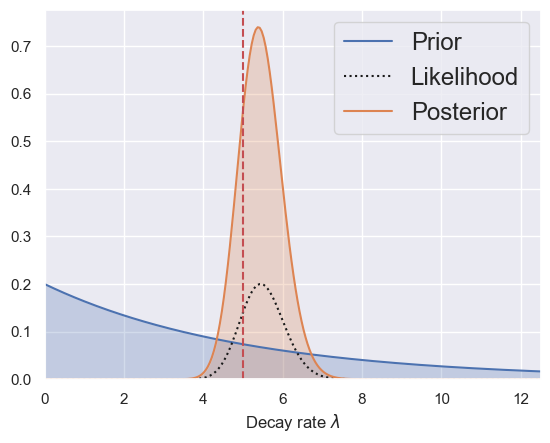

In [27]:
rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=100, true_lam=5)

## <span style="color:Orange">Problem 3</span>

In this problem you will solve the same decay rate inference problem but this time using a numerical estimate based on Markov-chain Monte Carlo (MCMC).

Recall that `MCMC_sample()` generates samples using a function proportional to the desired PDF. Implement the function below to evaluate the logarithm of the un-normalized posterior probability density:
$$
\log P(D\mid \lambda) + \log P(\lambda\mid \alpha, \beta) \; .
$$
Do not call your `decay_likelihood()` or `gamma_distribution()` functions in your implementation since the result has better accuracy if you apply the logarithm and simplify analytically. Since MCMC sampling only requires a function proportional to the desired PDF, you can drop any factors in $P(D\mid \lambda)$ or $P(\lambda\mid \alpha, \beta)$ that do not depend on $\lambda$.

In [ ]:
def decay_logf(lam, decay_times, prior_alpha, prior_beta):
    """Evaluate a function proportional to the log-posterior probability density.
    
    Parameters
    ----------
    lam : float
        Decay rate parameter.
    decay_times : array
        Array of observed decay times.
    prior_alpha : float
        Hyperparameter alpha for the prior Gamma distribution PDF.
    prior_beta : float
        Hyperparameter beta for the prior Gamma distribution PDF.
    
    Returns
    -------
    float
        log P(D|lam) + log P(lam|alpha,beta) up to a constant that does not
        depend on the value of lam. Returns -np.inf when lam <= 0.
    """
    if lam <= 0:
        return -np.inf
    # decay likelihood = np.prod(lam * np.exp(-lam * np.array(decay_times)))
    log_likelihood = len(decay_times) * np.log(lam) - lam * np.sum(decay_times)
    # gamma dist = (beta**alpha * lam**(alpha - 1) * np.exp(-beta * lam) / scipy.special.gamma(alpha))
    log_prior = (prior_alpha - 1) * np.log(lam) - prior_beta * lam
    return log_likelihood + log_prior

In [29]:
# A correct solution should pass these tests.
a, b = 1, 0.2
offset = decay_logf(1, [], a, b)
assert np.allclose(decay_logf(0.1, [], a, b) - offset, +0.18)
assert np.allclose(decay_logf(2, [], a, b) - offset, -0.2)
assert np.allclose(np.round(decay_logf(0.1, [1,2,1], a, b), 3) - offset, -7.128)
assert np.allclose(np.round(decay_logf(1, [1,2,1], a, b), 3) - offset, -4.000)
assert np.allclose(np.round(decay_logf(2, [1,2,1], a, b), 3) - offset, -6.121)

You can use the function below to test your numerical solution and compare with the posterior found using `rate_learn_plot` above.

In [30]:
import functools
import inspect
import emcee

def wrap(func, **kwargs):
    """Prepare an arbitrary function to use with emcee sampling.

    Emcee expects its parameters in a single list, but it is sometimes more
    convenient to write a function in terms of named parameters and
    hyperparameters. This method uses introspection to wrap an arbitrary
    function with named parameters so that it has the signature expected
    by emcee.

    For example:

        def f(x,y,a,b): ...
        wrap(f, x=[1], y=[2], a=3, b=4, c=3, d=4)

    returns a tuple (wrapped, ['x','y'], [1,2], {'c':3, 'd':4}) where:

      - wrapped([p,q]) calls f(x=p,y=q,a=3,b=4)
      - [1,2] are the initial values to use for parameters named ['x','y'].
      - {'c':3, 'd':4} are the input kwargs with args of f() removed.

    The square brackets identify floating arguments and specify their initial
    value. An optional callable to evaluate a log-prior can also be passed,
    for example:

        wrap(f, x=[1,px], y=[2,py], a=3, b=4, c=3, d=4)

    where px(x) and py(y) return the (un-normalized) log of the priors on
    x and y to use during posterior sampling.

    Parameters
    ----------
    func : callable
        The function that should be prepared. It is assumed to have only
        numerical arguments that accept any floating point values.
    **kwargs : keyword arguments
        All arguments of func must be included and assigned a value.
        Arguments assigned a floating point value are considered fixed
        during sampling.  Arguments assigned a floating point value
        within a list, e.g., [1.2], will be sampled using the initial
        value provided.  Sampled arguments can optionally also specify
        a log-prior distribution using, e.g. [1.2, lnprior], where lnprior
        is a function of the sampled argument that returns the log prior
        probability density (which does not need to be normalized).

    Returns
    -------
    tuple
        Tuple (wrapped, names, values, kwargs). See example above for details.
    """
    fixed = {}
    names, values, lnpriors = [], [], []
    funcsig = inspect.signature(func)
    try:
        funcargs = {name: kwargs[name] for name in funcsig.parameters}
    except KeyError:
        raise ValueError('Missing arguments.')
    bound = funcsig.bind(**funcargs)
    bound.apply_defaults()
    NoPrior = lambda x: 0.
    for name, value in bound.arguments.items():
        if isinstance(value, list):
            names.append(name)
            values.append(value.pop(0))
            lnpriors.append(value.pop(0) if value else NoPrior)
            if value:
                raise ValueError('Invalid syntax for argument {}.'.format(name))
        else:
            fixed[name] = value
    partial = functools.partial(func, **fixed)
    def wrapped(theta):
        if len(theta) != len(names):
            raise ValueError('expected list of {} values.'.format(len(names)))
        result = 0.
        for lnprior, value in zip(lnpriors, theta):
            result += lnprior(value)
            if not np.isfinite(result):
                # theta is not allowed by this prior.
                return -np.inf
        args = dict(zip(names, theta))
        result += partial(**args)
        return result
    # Remove function args from kwargs.
    for name in funcargs:
        kwargs.pop(name, None)
    return wrapped, names, values, kwargs


def sample(func, names, values, nwalkers=20, nsamples=1000, abs_rms=1e-4,
           frac_rms=1e-3, burnin=100, random_state=None):
    """Generate MCMC samples of the un-normalized PDF func() using emcee.

    Can be used standalone but intended to work with :func:`wrap`.

    Initial values for each walker are Gaussian samples centered on the
    input values with an RMS of max(abs_rms, frac_rms * values).

    Parameters
    ----------
    func : callable
        Evaluate the log PDF to sample. Passed a single list of parameter
        values. Can be prepared using :func:`wrap`.
    names : iterable
        List of names for each floating parameter.  Used to label columns
        in the returned DataFrame. Can be prepared using :func:`wrap`.
    values : iterable
        List of initial values for each floating parameter.  Used to center
        random initial values for each walker. Can be prepared using
        :func:`wrap`.
    nwalkers : int
        The number of emcee walkers to use.
    nsamples : int
        The total number of samples to return, after combining walkers
        and trimming initial burnin.
    abs_rms : float
        Used to set walker initial values.  See above for details.
    rel_rms : float
        Used to set walker initial values.  See above for details.
    burnin : int
        The number of samples to remove from each walker's chain.
    random_state : np.random.RandomState or None
        The random state to use for reproducible chains.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, using the inputs names for columns.
    """
    if random_state is None:
        random_state = np.random.RandomState()
    # Generate sampler starting points.
    ndim = len(names)
    values = np.array(values, float)
    initial = np.tile(values, (nwalkers, 1))
    rms = np.maximum(abs_rms, frac_rms * values)
    initial += rms * random_state.normal(size=(nwalkers, ndim))
    # Initialize and run sampler.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
    n_per_chain = 1 + nsamples // nwalkers + burnin
    sampler.run_mcmc(initial, n_per_chain, rstate0=random_state.get_state())
    # Remove burnin and return results in a DataFrame.
    chain = sampler.chain[:, burnin:].reshape(-1, ndim)[:nsamples]
    return pd.DataFrame(chain, columns=names)


def MCMC_sample(func, **kwargs):
    """Generate random samples from an un-normalized PDF.

    See :func:`wrap` and :func:`sample` for details.

    Parameters
    ----------
    func : callable
        Function to evaluate log(f(...)) where f(...) is proportional
        to the desired probability density.  Will be wrapped to
        determine which arguments are sampled and which are fixed.
    **kwargs : keyword arguments
        Used to configure the wrapping of func and the sampler.

    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, with one named column per
        sampled argument of the input function.
    """
    # Wrap the input function.
    wrapped, names, values, kwargs = wrap(func, **kwargs)
    # Generate emcee samples.
    return sample(wrapped, names, values, **kwargs)

In [31]:
def MCMC_rate_learn_plot(prior_alpha, prior_beta, num_decays, true_lam, seed=123):
    # Generate some random decays using the true decay rate.
    gen = np.random.RandomState(seed=seed)
    decay_times = scipy.stats.expon.rvs(scale=1 / true_lam, size=num_decays, random_state=gen)
    # Generate MCMC samples of the decay rate for this data with this prior.
    samples = MCMC_sample(decay_logf, lam=[true_lam], decay_times=decay_times,
                          prior_alpha=prior_alpha, prior_beta=prior_beta, nsamples=20000)
    # Plot samples.
    plt.hist(samples['lam'], range=(0, 2.5 * true_lam), bins=40, density=True)
    plt.axvline(true_lam, c='r', ls='--')
    plt.xlabel('Decay rate $\lambda$')
    plt.xlim(0, 2.5 * true_lam)

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
C:\Users\TangyKiwi\AppData\Local\Temp\ipykernel_25100\1050318017.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Decay rate $\lambda$')


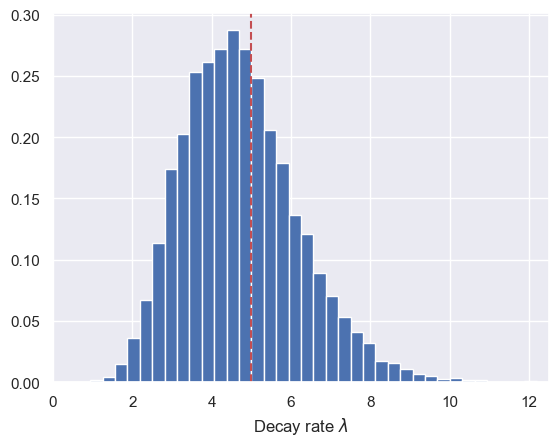

In [32]:
MCMC_rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=10, true_lam=5)

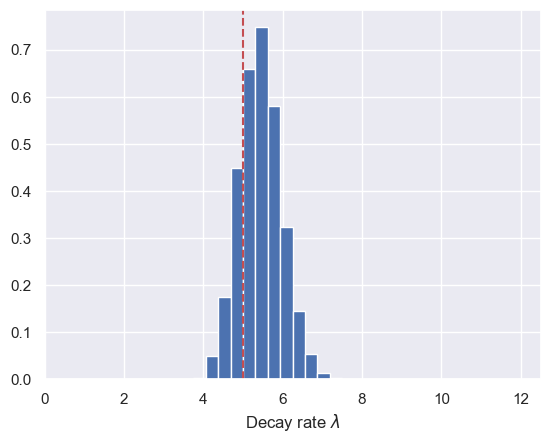

In [33]:
MCMC_rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=100, true_lam=5)